In [1]:
import matplotlib.pyplot as plt
import numpy as np


class GridWorld:

    def __init__(self, reward_wall=-5):
        # initialize grid with 2d numpy array
        # >0: goal
        # -1: wall/obstacles
        # 0: non-terminal
        self._grid = np.array(
            [[0, 0, 0, 0, 0, -1, 0, 0],
             [0, 0, 0, -1, 0, 0, 0, 5],
             [0, 0, 0, -1, -1, 0, 0, 0],
             [0, 0, 0, -1, -1, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0]
             ])
        # wall around the grid, padding grid with -1
        self._grid_padded = np.pad(self._grid, pad_width=1, mode='constant', constant_values=-1)
        self._reward_wall = reward_wall

        # set start state
        self._start_state = (1, 1)
        self._random_start = False

        # store position of goal states and non-terminal states
        idx_goal_state_y, idx_goal_state_x = np.nonzero(self._grid > 0)
        self._goal_states = [(idx_goal_state_y[i], idx_goal_state_x[i]) for i in range(len(idx_goal_state_x))]

        idx_non_term_y, idx_non_term_x = np.nonzero(self._grid == 0)
        self._non_term_states = [(idx_non_term_y[i], idx_non_term_x[i]) for i in range(len(idx_non_term_x))]

        # store the current state in the padded grid
        self._state_padded = (self._start_state[0] + 1, self._start_state[1] + 1)

    def get_state_num(self):
        # get the number of states (total_state_number) in the grid, note: the wall/obstacles inside the grid are
        # counted as state as well
        return np.prod(np.shape(self._grid))

    def get_state_grid(self):

        state_grid = np.multiply(np.reshape(np.arange(self.get_state_num()), self._grid.shape), self._grid >= 0) - (
                self._grid == -1)

        return state_grid, np.pad(state_grid, pad_width=1, mode='constant', constant_values=-1)

    def get_current_state(self):
        # get the current state as an integer from 0 to total_state_number-1
        y, x = self._state_padded
        return (y - 1) * self._grid.shape[1] + (x - 1)

    def int_to_state(self, int_obs):
        # convert an integer from 0 to total_state_number-1 to the position on the non-padded grid
        x = int_obs % self._grid.shape[1]
        y = int_obs // self._grid.shape[1]
        return y, x

    def reset(self):
        # reset the gridworld
        if self._random_start:
            # randomly start at a non-terminal state
            idx_start = np.random.randint(len(self._non_term_states))
            start_state = self._non_term_states[idx_start]
            self._state_padded = (start_state[0] + 1, start_state[1] + 1)
        else:
            # start at the designated start_state
            self._state_padded = (self._start_state[0] + 1, self._start_state[1] + 1)

    def step(self, action):
        # take one step according to the action
        # input: action (integer between 0 and 3)
        # output: reward           reward of this action
        #         terminated       1 if reaching the terminal state, 0 otherwise
        #         next_state       next state after this action, integer from 0 to total_state_number-1)
        y, x = self._state_padded

        if action == 0:  # up
            new_state_padded = (y - 1, x)
        elif action == 1:  # right
            new_state_padded = (y, x + 1)
        elif action == 2:  # down
            new_state_padded = (y + 1, x)
        elif action == 3:  # left
            new_state_padded = (y, x - 1)
        else:
            raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

        new_y, new_x = new_state_padded
        if self._grid_padded[new_y, new_x] == -1:  # wall/obstacle
            reward = self._reward_wall
            new_state_padded = (y, x)
        elif self._grid_padded[new_y, new_x] == 0:  # non-terminal cell
            reward = 0.
        else:  # a goal
            reward = self._grid_padded[new_y, new_x]
            self.reset()
            terminated = 1
            return reward, terminated, self.get_current_state()

        terminated = 0
        self._state_padded = new_state_padded
        return reward, terminated, self.get_current_state()

    def plot_grid(self, plot_title=None):
        # plot the grid
        plt.figure(figsize=(5, 5),dpi=200)
        plt.imshow(self._grid_padded <= -1, cmap='binary', interpolation="nearest")
        ax = plt.gca()
        ax.grid(0)
        plt.xticks([])
        plt.yticks([])

        if plot_title:
            plt.title(plot_title)

        plt.text(
            self._start_state[1] + 1, self._start_state[0] + 1,
            r"$\mathbf{S}$", ha='center', va='center')
        for goal_state in self._goal_states:
            plt.text(
                goal_state[1] + 1, goal_state[0] + 1,
                "{:d}".format(self._grid[goal_state[0], goal_state[1]]), ha='center', va='center')
        h, w = self._grid_padded.shape
        for y in range(h - 1):
            plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
        for x in range(w - 1):
            plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)

    def plot_state_values(self, state_values, value_format="{:.1f}",plot_title=None):
        # plot the state values
        # input: state_values     (total_state_number, )-numpy array, state value function
        #        plot_title       str, title of the plot
        plt.figure(figsize=(5, 5),dpi=200)
        plt.imshow((self._grid_padded <= -1) + (self._grid_padded > 0) * 0.5, cmap='Greys', vmin=0, vmax=1)
        ax = plt.gca()
        ax.grid(0)
        plt.xticks([])
        plt.yticks([])

        if plot_title:
            plt.title(plot_title)

        for (int_obs, state_value) in enumerate(state_values):
            y, x = self.int_to_state(int_obs)
            if (y, x) in self._non_term_states:
                plt.text(x + 1, y + 1, value_format.format(state_value), ha='center', va='center')

        h, w = self._grid_padded.shape
        for y in range(h - 1):
            plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
        for x in range(w - 1):
            plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)

    def plot_policy(self, policy, plot_title=None):
        # plot a deterministic policy
        # input: policy           (total_state_number, )-numpy array, contains action as integer from 0 to 3
        #        plot_title       str, title of the plot
        action_names = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
        plt.figure(figsize=(5, 5),dpi=200)
        plt.imshow((self._grid_padded <= -1) + (self._grid_padded > 0) * 0.5, cmap='Greys', vmin=0, vmax=1)
        ax = plt.gca()
        ax.grid(0)
        plt.xticks([])
        plt.yticks([])

        if plot_title:
            plt.title(plot_title)

        for (int_obs, action) in enumerate(policy):
            y, x = self.int_to_state(int_obs)
            if (y, x) in self._non_term_states:
                action_arrow = action_names[action]
                plt.text(x + 1, y + 1, action_arrow, ha='center', va='center')
    # Transition Function, return reward and transition probability
    def transition(self, action):
        if action == 0:  # up
            anchor_state_padded = (0, 1)
        elif action == 1:  # right
            anchor_state_padded = (1, 2)
        elif action == 2:  # down
            anchor_state_padded = (2, 1)
        elif action == 3:  # left
            anchor_state_padded = (1, 0)
        else:
            raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

        state_num = self.get_state_num()
        h, w = self._grid.shape
        y_a, x_a = anchor_state_padded
        reward = np.multiply(self._grid_padded[y_a:y_a + h, x_a:x_a + w],self._grid==0)

        state_grid, state_grid_padded = self.get_state_grid()
        next_state = state_grid_padded[y_a:y_a + h, x_a:x_a + w]
        next_state = np.multiply(state_grid, next_state == -1) + np.multiply(next_state, next_state > -1)
        next_state[self._grid == -1] = -1
        next_state[self._grid > 0] = state_grid[self._grid > 0]

        next_state_vec = next_state.flatten()
        state_vec = state_grid.flatten()

        probability = np.zeros((state_num, state_num))
        probability[state_vec[state_vec > -1], next_state_vec[state_vec > -1]] = 1
        return reward.flatten(), probability
    
    # Value Iteration Algorithm
    def value_iteration(self, gamma,eps = 1e-5,
        max_iter= 2000):
    # input: 
    #         gamma,     (float 0-1) discount of the return
    #         eps,       (float) stopping criteria
    #         max_iter,  (int) maximum number of iteration
    # output: 
    #         optim value,  (1d numpy array, float) optimal value function 
    #         optim_policy, (1d numpy array, int {0,1,2,3}) optimal policy

        
        policy = []
        
        v = np.zeros((self.get_state_num(),))
        
        for _ in range(max_iter):
            
            # Policy Update
            q = np.zeros((self.get_state_num(),4))  # q(s,a)

            for action in range(4):
                    reward, tran_prob = self.transition(action)
                    q[:,action] = reward+gamma* np.matmul(tran_prob,v)
        
            policy = np.argmax(q,axis=1)
            
            # Value Update
            v_tmp = np.max(q,axis = 1) # v_{k+1}(s) = max_a q_k(s,a)
            if np.linalg.norm(v_tmp-v) < eps:
                break
            else:
                v = v_tmp
            
        
        optim_value = v
        optim_policy = policy
        

        return optim_value, optim_policy
    
    # Policy Iteration Algorithm
    def policy_iteration(self,gamma=0.9,max_it=1000,tol=1e-5):
        
        # stochastic policy
        stochastic_mat = np.random.rand(self.get_state_num(),4)
        pi = stochastic_mat / stochastic_mat.sum(axis=1)[:,None] # pi(a|s) 
        policy = np.argmax(pi,axis=1)
        
        
        for _ in range(max_it):

            # Policy Evaluation
            v = np.zeros((self.get_state_num(),))
            for _ in range(max_it):
                value_temp = np.zeros((self.get_state_num(),))
                for action in range(4):
                    reward, tran_prob = self.transition(action)
                    value_temp = value_temp + pi[:,action]*(reward+gamma* np.matmul(tran_prob,v))
                if np.linalg.norm(value_temp-v)<tol:
                    break
                else:
                    v = value_temp

            v_final = v
        
            # Policy Improvement
            q = np.zeros((self.get_state_num(),4)) # q(s,a)
            for action in range(4):
                    reward, tran_prob = self.transition(action)
                    q[:,action] = reward+gamma* np.matmul(tran_prob,v_final)
            now_policy = np.argmax(q,axis=1)
            
            # check if policy is stable
            if np.array_equal(policy,now_policy):
                optimal_policy = policy
                optimal_v = v_final
                break
            else:
                policy = now_policy
                pi = np.zeros((self.get_state_num(),4))
                pi[np.arange(self.get_state_num()),policy] = 1 # greedy policy
        
        return optimal_v,optimal_policy

In [2]:
env = GridWorld()

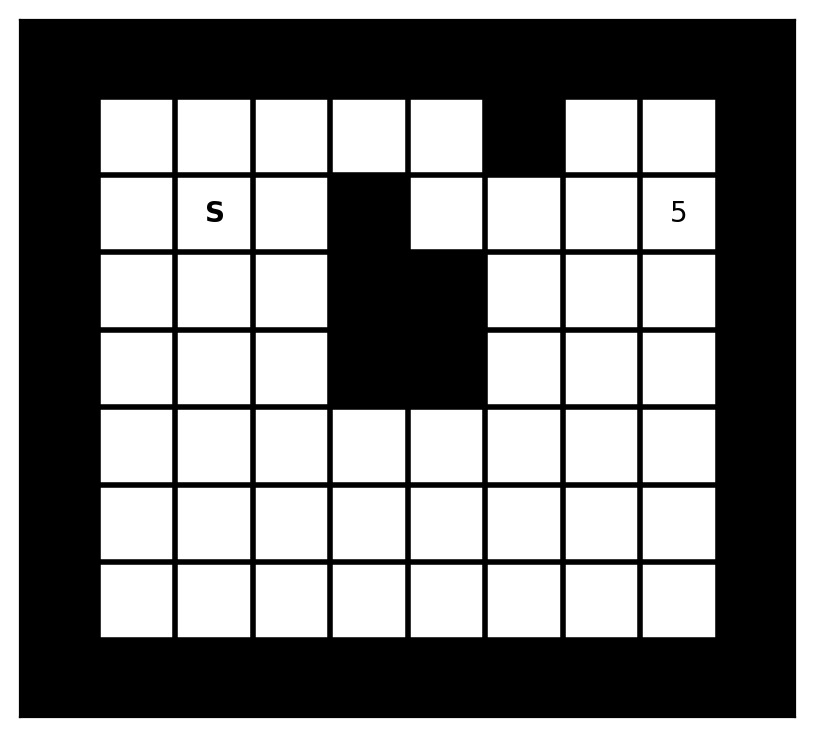

In [3]:
env.plot_grid()

In [5]:
optim_value, optim_policy = env.value_iteration(0.9)

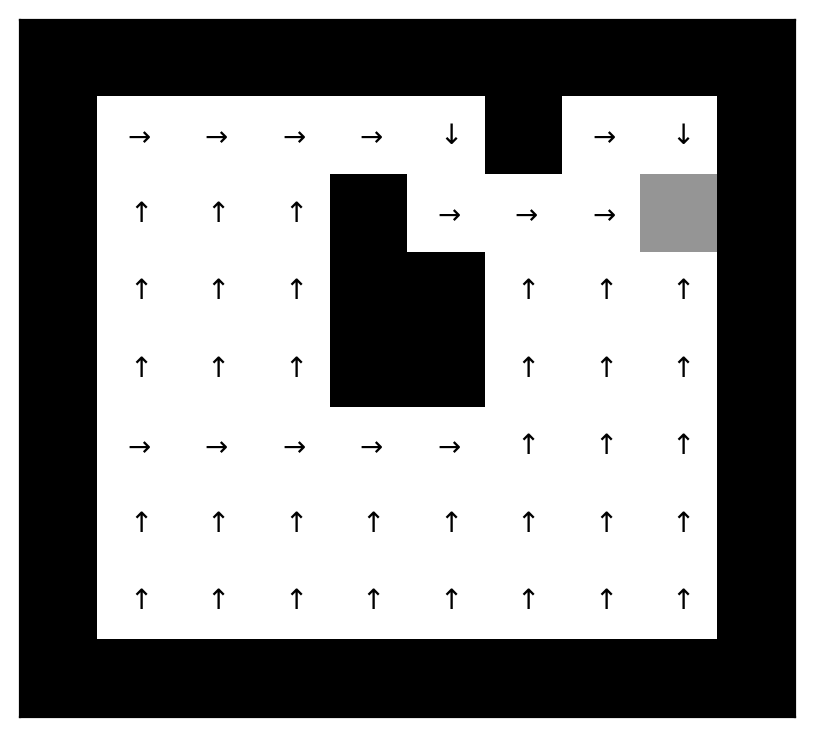

In [7]:
env.plot_policy(optim_policy)

In [ ]:
env.plot_state_values(optim_value)